# TO DO: 

* wordcloud for the whole vocabular
* wordclouds by taster
* explain more why gradient boosting
* plot outputs of GB
* recommend!
* evaluate GB on test set
* update Organization of notebook chapter

# #winerec - A Wine Recommendation System

This notebook presents the code necessary to build the wine recommendation system. Its purpose is to show the process, explain and document the decisions taken and demonstrate the sytem.

## Organization of the Notebook

The organization of the notebook follows the different steps undertaken to create the recommendation system:

1. Data Exploration: source of the data, the different variables and exploratory plots
2. Data Processing:
    1. Data selection, filtering and handling of missing values
    2. Tokenization and cleaning of the text descriptions
3. Data Understanding
    1. Bivariate Data Exploration
4. Testing Different Recommendation Systems
5. Conclusion

In [196]:
# IMPORTING THE NECESSARY PACKAGES AND FUNCTIONS:

# generic:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 

# more specific:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer # Normalize samples individually to unit norm.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler # used to compute stacked percentages barplots
import pickle # to save models, for instance LDA outputs

# NLP:
import spacy # version 2.2.1 
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD # LSA
from sklearn.decomposition import NMF # NMF
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis # used to visualize and plot ouptut of LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [24]:
# some general preferences, definitions:

mycolor = "steelblue" # change the color of the one-color plots

## 1. Data Exploration

The [dataset](https://www.kaggle.com/zynicide/wine-reviews) was uploaded on Kaggle by Zack Thout. It consists of 140’000 wine reviews scraped from the [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) magazine website. I use a new version of the dataset, extracted on March 2019 (c.f. [discussion](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970)) and found [here](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970).  

We first explore the data. The observations will guide the next data processing steps.

In [6]:
# load data: 
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
initial_number_of_rows = raw_winedata.shape[0]
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [7]:
# variables types:
raw_winedata.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
vintage                  float64
dtype: object

In [8]:
# checking for missing values:
raw_winedata.isnull().sum()

country                     61
description                  0
designation              40182
points                       0
price                     9658
province                    61
region_1                 22886
region_2                 86832
taster_name              24917
taster_twitter_handle    30649
title                        0
variety                      1
winery                       0
vintage                   5234
dtype: int64

### Variables in the Dataset

|variable|short explanation|
|--------|-----------------|
|country|The country that the wine is from|
|description|Wine description by a _sommelier_, identified in the column "taster"|
|designation|The vineyard within the winery where the grapes that made the wine are from|
|points|The number of points WineEnthusiast rated the wine on a scale of 80-100 (wines deemed unacceptable (rating < 80) are not reviewed)|
|price|The cost for a bottle of the wine in USD |
|province|The province or state that the wine is from|
|region_1|The wine growing area in a province or state (e.g. Napa)|
|region_2|Sometimes there are more specific regions specified within a wine growing area (e.g. Rutherford inside the Napa Valley)|
|taster_name|Name of the _sommelier_ who wrote the description|
|taster_twitter_handle| |
|title|The title of the wine review|
|variety|The type of grapes used to make the wine (e.g. Pinot Noir)|
|winery|The winery that made the wine|
|vintage|Extracted from "title" when present|


### Univariate Distributions

We then have a look at the distribution of the most important variables.


#### Description

The variable that interest us the most is the variable _description_, as we will base our content-based recommendation system on it. There are no missing values, however some descriptions are duplicated:

In [9]:
# inspect duplicated description:
duplicates_description  = raw_winedata[raw_winedata.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)
# duplicates_description # if want to print duplicates

# note: there are no full duplicates of row:
# duplicates = raw_winedata[raw_winedata.duplicated()] # is empty

number of duplicated descriptions:  38.0


No rows are full duplicates. However, 38 descriptions occur twice. After inspection, usually the descriptions occuring twice are two different wines coming from the same region. Sometimes even from the same winery, but with a different designation (e.g. "reserve"). We cannot know if these duplicate descriptions are valid tasting description or copy-paste errors from the tasters. Thus, we could keep them and assume that the taster did voluntarily copy their description because the wine was indeed very similar. However we have to keep in mind that if two descriptions are exact copies, the similarity distance that we will compute, or tf-idf vectors or topics, or actually any measure will be the same.  

To stay on the safe side, we will remove these duplicates when processing data.

In [10]:
# Some examples of descriptions:
for i in range(1,5):
    print(raw_winedata.description[i], '\n')

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. 

Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew. 



Already with this very small subset, we note that not all words or sentences used are directly related to taste. For instance: "although it will certainly be better from 2016" or "Much like the regular bottling from 2012". 

Number of characters in the longest descritption:  829 ; and in the shortest:  20 . The mean is  242.97805348227968  and the median 237.0


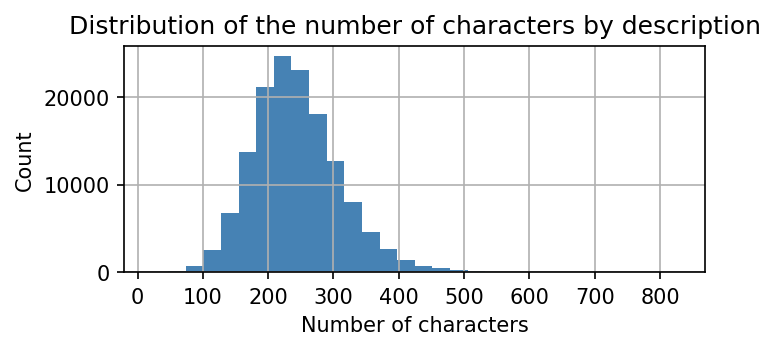

In [60]:
# length of the descriptions:
descr_lengths = raw_winedata.description.apply(len)
print("Number of characters in the longest descritption: ", max(descr_lengths), 
      '; and in the shortest: ', min(descr_lengths), '. The mean is ',
     np.mean(descr_lengths), ' and the median', np.median(descr_lengths))
# distribution: 
plt.figure(figsize=(5,2), dpi=150)
raw_winedata.description.apply(len).hist(bins=30, color=mycolor)
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.title('Distribution of the number of characters by description')
plt.savefig("../figures/hist_descr_length.png", bbox_inches='tight')
plt.show()

Some descriptions are really short. Do they still seem to carry enough relevant information for NLP?

In [12]:
# # Use this code to print the short descriptions
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
# for descr in short_descr:
#     print(descr)

After visual inspection, we found that short descriptions usually still carry relevant information, thus we will only get rid of the descriptions that are under 45 characters long.  

We can quickly have a look at the most frequent words used:

In [14]:
def get_top_n_words(corpus, n=None):
    """
        List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    # Tokenization
    # Note: we do not care here much about the details of the parameters,
    # we just want to have a look at the most common words: 
    vectorizer = CountVectorizer(analyzer='word',       
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             max_features=1000,             # max number of unique words
                            )
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print(get_top_n_words(raw_winedata['description'], 100))

[('wine', 88822), ('flavors', 68104), ('fruit', 54225), ('palate', 45084), ('aromas', 45055), ('acidity', 39090), ('finish', 38132), ('tannins', 35255), ('drink', 34930), ('black', 32737), ('cherry', 32237), ('ripe', 30574), ('red', 24253), ('spice', 21223), ('notes', 20654), ('nose', 20166), ('oak', 19383), ('rich', 19284), ('fresh', 18996), ('berry', 18963), ('dry', 18143), ('plum', 16635), ('apple', 15162), ('fruits', 14888), ('white', 14585), ('soft', 14472), ('offers', 14298), ('light', 14253), ('blend', 14128), ('texture', 14034), ('blackberry', 13768), ('sweet', 13713), ('crisp', 13666), ('dark', 13604), ('bodied', 13356), ('citrus', 12873), ('bright', 12222), ('shows', 12119), ('vanilla', 11766), ('juicy', 11249), ('cabernet', 11245), ('lemon', 11240), ('pepper', 11233), ('green', 10533), ('fruity', 10422), ('raspberry', 10369), ('firm', 10253), ('good', 10065), ('balanced', 9594), ('peach', 9398), ('touch', 9321), ('dried', 9263), ('chocolate', 8987), ('pear', 8871), ('charact

This looks quite promising, as most of those words are taste descriptors. 

#### Country

In [58]:
def my_barplot(dataframe, variable, title=None, xlabel=None, ylabel=None, fig_height=6):
    """
        bar plot of the value counts a variable in a df.
        includes NAs, as !MISSING! in the plots
    """
    plt.figure(figsize=(7 ,fig_height))
    
    df_toplot = pd.DataFrame(dataframe[variable].value_counts(dropna=False).reset_index(level=0))
    df_toplot.columns = ['variable', 'count']
    # necessary for the NaN to appear on the plots:
    df_toplot['variable'] = np.where(df_toplot['variable'].isnull(), '!MISSING!', df_toplot['variable'])
    
    sns.barplot(x='count', y='variable', data=df_toplot, color=mycolor)
    plt.title(title)
    plt.ylabel(variable)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.savefig("../figures/"+"barplot_n_descr_by_"+str(variable)+".png", dpi=200, bbox_inches='tight')
    # note: , bbox_inches='tight' so that the full plot is saved, not labels are cut
    plt.show()
    

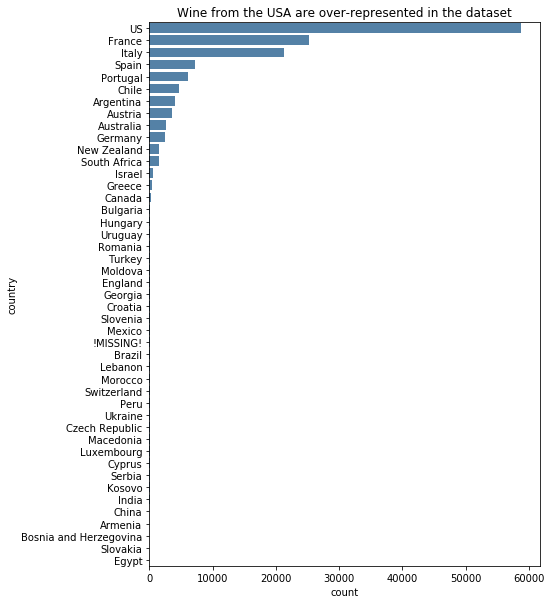

In [59]:
my_barplot(raw_winedata, 'country', title='Wine from the USA are over-represented in the dataset', fig_height=10)

#### Variety

There are 758 different varieties in the dataset
If we keep only the varieties represented by 500 wines or more, 
we still have 122856 wines in the dataset, and 42 unique varieties:


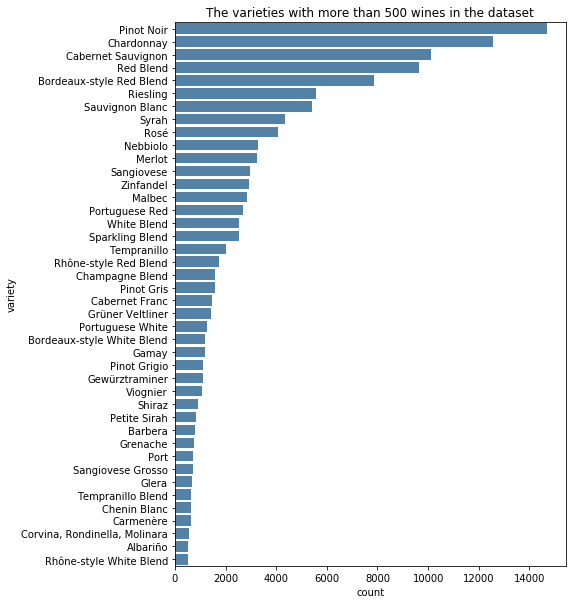

In [61]:
threshold_n_wines = 500
variety_counts = raw_winedata.variety.value_counts()

print('There are', raw_winedata.variety.nunique(), 'different varieties in the dataset')
print('If we keep only the varieties represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].variety.nunique(),
     'unique varieties:')

my_barplot(raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])], 
           'variety', 
           title='The varieties with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


#### Province

There are 456 different provinces in the dataset
If we keep only the provinces represented by 500 wines or more, 
we still have 124904 wines in the dataset, and 41 unique provinces:


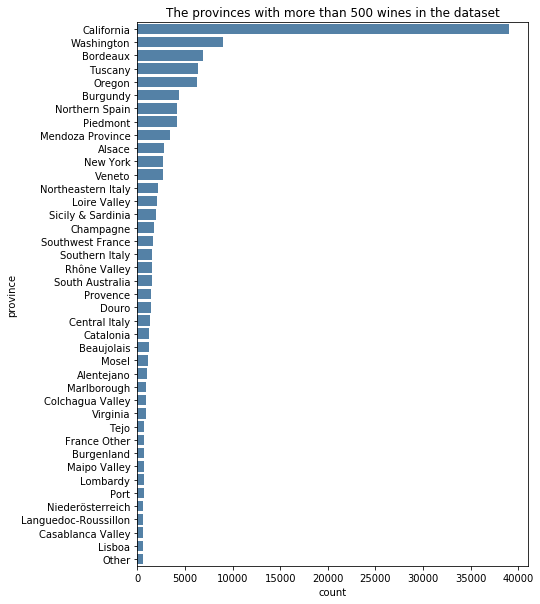

In [62]:
threshold_n_wines = 500
province_counts = raw_winedata.province.value_counts()

print('There are', raw_winedata.province.nunique(), 'different provinces in the dataset')
print('If we keep only the provinces represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].province.nunique(),
     'unique provinces:')

my_barplot(raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])], 
           'province', 
           title='The provinces with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


We note that there is a province named "Other". All those wines are coming from Argentina:

In [63]:
raw_winedata[raw_winedata.province == 'Other'].country.value_counts()

Argentina    546
Name: country, dtype: int64

There is one other province in Argentina, Mendoza:

In [64]:
raw_winedata[raw_winedata.country == 'Argentina'].province.value_counts()

Mendoza Province    3451
Other                546
Name: province, dtype: int64

Thus, we will rename the province "Other" to "Argentina Other" during the data processing step below.

#### Taster

Unfortunately a large portion of the data lack a tester name. This has to be kept in mind if we want to check the assumption that their is an "universal" way of describing wine and that vocabulary of the different taster is similar.  

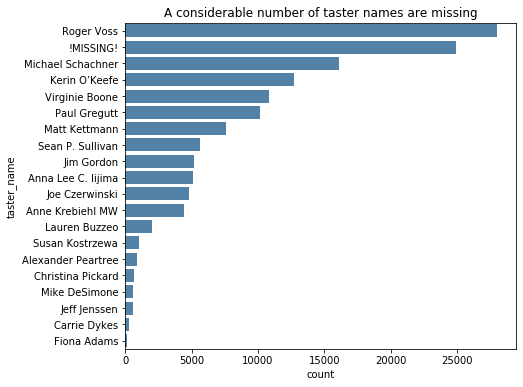

In [65]:
my_barplot(raw_winedata, 'taster_name', title='A considerable number of taster names are missing', fig_height=6)

The variables that we just explored are the most significant for this project. Let's have a quick look at the points attributed to the wine.

#### Points

Note that wines with a review less than 80 points are not reviewed, thus not in the dataset. An alternative project with this dataset could be to try to predict the points based on the text descriptions.  

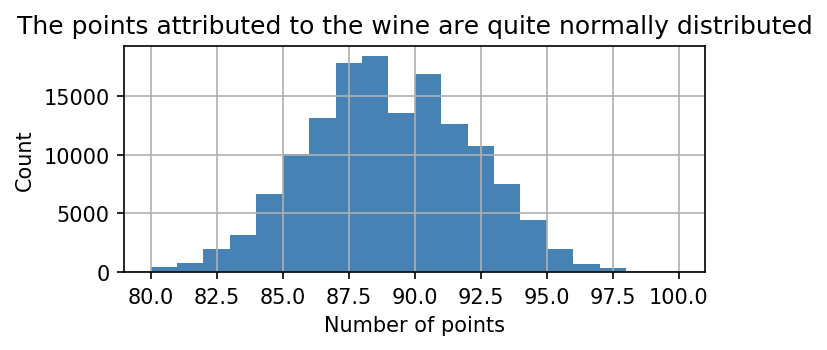

In [66]:
# distribution of points attributed to the wines:
plt.figure(figsize=(5,2), dpi=150)
raw_winedata.points.hist(bins=20, color=mycolor)
plt.xlabel('Number of points')
plt.ylabel('Count')
plt.title('The points attributed to the wine are quite normally distributed')
plt.savefig("../figures/hist_points.png", bbox_inches='tight')
plt.show()

**This dataset is a sample that is not representative of the wine production in the world**. It only represent what was could be scraped on the WineEnthusiast website, which is aimed at the american wine market. There is thus an important sampling bias in this dataset. More will be commented on this in the presentation.


## 2. Data Processing

In this step, we process, filter and clean the data. The data processing decisions are based on the initial data exploration, but also on later steps in the analysis pipeline.  

### 2.A. Data selection, filtering and handling of missing values

In [71]:
# creation of a dataframe that will contain the processed data:
winedata_processing = raw_winedata.copy()
initial_number_of_rows = winedata_processing.shape[0]

# WARNING: the following code chunks need to be run starting from this one !

In [72]:
# Keep only varieties that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
variety_counts = winedata_processing.variety.value_counts()
winedata_processing = winedata_processing[winedata_processing.variety.isin(variety_counts.index[variety_counts.gt(n)])] # pandas.DataFrame.gt = get greater

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])


Number of rows removed:  18761 . New number of rows: 122856


In [73]:
# Renaming the province "Other" to "Argentina Other":
winedata_processing.loc[:,'province'] = np.where(winedata_processing.province == 'Other', 
                                                'Argentina Other',
                                                winedata_processing.province)

In [74]:
# Keep only provinces that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
province_counts = winedata_processing.province.value_counts()
winedata_processing = winedata_processing[winedata_processing.province.isin(province_counts.index[province_counts.gt(n)])]

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  15932 . New number of rows: 106924


In [75]:
# Remove duplicate descriptions:
old_number_of_rows = winedata_processing.shape[0]

# Note: we are conservative, and do not keep any version of the duplicates
winedata_processing = winedata_processing.drop_duplicates(subset='description', keep=False)

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  44 . New number of rows: 106880


In [76]:
# remove descrptions that are shorter than 45 characters long:
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.description.apply(len) > 45]
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  7 . New number of rows: 106873


In [77]:
# remove wines coming from the province "other":
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.province != 'Other']
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0],
     '. They were apparently already removed with during the previous cleaning steps.')

Number of rows removed:  0 . New number of rows: 106873 . They were apparently already removed with during the previous cleaning steps.


In [78]:
# We drop the columns "taster_twitter_handle" and "vintage",
# as they are useless for this analysis
winedata_processing.drop(['taster_twitter_handle', 'vintage'], axis=1, inplace=True)

In [79]:
# finally, we save the processed data in a new dataframe, that we will use for the rest of the project:
winedata = winedata_processing.copy()

# and we reset the indexes of the data:
winedata.reset_index(inplace=True)

In [80]:
print("We have now a dataset of", winedata.shape[0], 'rows with', 
      winedata.shape[1], 'features.')

We have now a dataset of 106873 rows with 13 features.


### 2.B. Tokenization and cleaning of the text descriptions

We add a new column in the dataframe with the tokenized and clean descriptions, using a custom tokenizer.    

The corpus-specific stopwords (domain_specific_stopwords, variety_stopwords, province_stopwords) listed below have been updated after an initial iteration of building the recommendation system and the observations collected.  Notably, we would prefer to not have wine varieties and province inside the text descriptions, as our goal is to recommand wines based on the taste description.  

In [81]:
domain_specific_stopwords = ['$', ' ', '’s', 'wine', 'winemaker', 'winemaking', 'winery',
                             'château', 'village', 'domaine',
                             'côte', 'saint', 'village', 'parcel', 'parcels',
                             'I', 'flavors', 'vineyard', 'vintage',
                             'now-2015', 'now-2018', 'now-2025', 
                             '2015', '2016', '2017', '2018', '2019', '2020', # not sure why these numbers are not...
                             '2021', '2022', '2023', '2025', '2028', '2030'] # cleand by spacy "is_digit/like_num"
# Other potential words to consider removing:
# douro, nacional, widely, muscat, willamette, bordeaux, pommard, rioja, barbaresco, chianti...

# a list of all wine varieties. this is not perfect as some varieties are compound words. But it's a start.
variety_stopwords = winedata.variety.unique().tolist()
variety_stopwords = [str(variety).lower() for variety in variety_stopwords] # convert to lowercase
# we add some notable varieties to the list:
variety_stopwords = variety_stopwords + ['pinot', 'gris', 'noir', 'grigio', 'cabernet', 
                                         'cabernets', 'sauvignon', 'sirah', 'tempranillo', 
                                         'chenin', 'sangiovese', 'grüner', 'veltliner', 'corvina', 
                                         'rondinella', 'molinara', 'franc', 'blanc', 'blend',
                                         'franc', 'mourvèdre']

# a list of all wine provinces. 
province_stopwords = winedata.province.unique().tolist()
province_stopwords = [str(province).lower() for province in province_stopwords] # convert to lowercase
# we add some notable province-related words to the list:
province_stopwords = province_stopwords + ['france', 'sicily', 'sardinia', 'mendoza', 'spain', 
                                           'australia', 'italy', 'loire', 'beaujolais']


In [82]:
# Standard model used for tokenization.
# When using another model, we will have to load it and redefine "nlp"

# We do not need word vectors here, so we can upload the small English model from spaCy:
# We do not need PoS tags, dependencies or named entities, so we disable them (run faster!):
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

In [83]:
def tokenize_and_clean(description):
    """
        Our basic tokenizer function. It takes as input:
            - a pd.Series of the descriptions
            - a nlp model
        After tokenizing, it cleans the data too,
        and returns a list of tokens. 
    """
    
#     # eventually clean the description with regular expressions here:
#     pattern = "[\[].*?[\]]" # an example of an regex
#     description = re.sub(pattern, "", description) # remove this pattern from description.

    # Tokenize:
    mytokens = nlp(description)

    # Removing stopwords, punctuation, numbers and convert to lower_case
    mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop and not token.like_num and not token.is_digit]
    
    # remove domain-specific stopwords:
    mytokens = [token for token in mytokens if token not in domain_specific_stopwords]
            
    # remove wine variety occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in variety_stopwords]
    
    # remove wine province occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in province_stopwords]
                
    # Return preprocessed list of tokens
    return mytokens


In [84]:
# Tokenization:
time0 = time.time()

# we store our tokenized descriptions in a new column of the dataframe, 
# in the form of a list of words,
# which we will be able to use later in the analysis as input for different algorithms.

winedata.loc[:,'tokenized_descriptions'] = winedata.description.apply(tokenize_and_clean)

print('Done! Tokenization took', time.time()-time0, 'seconds.')

Done! Tokenization took 25.946377992630005 seconds.


In [85]:
def concatenate_list_of_words_in_one_string(list_of_words):
    """
        build one string with a list of words, with a space in the middle
    """
    return " ".join(list_of_words)

In [86]:
# we also store our tokenized descriptions as one string, 
# as it will be useful later, e.g. to compute tf-ifd.
winedata.loc[:,'token_descr_as_string'] = winedata.tokenized_descriptions.apply(
    concatenate_list_of_words_in_one_string)


In [87]:
# a csv where we save our processed data:
winedata.to_csv(path_or_buf='../data/winedata_processed_and_tokenized.csv', index=False)

## 3. Understanding the Data

We do some bivariate plots and apply some supervised learning techniques to better understand the data and test some of our assumptions before building the recommender system.


### Bivariate Relationships

We suppose that wines from different provinces or variety taste differently. We suppose that province and variety are two of the main drivers of the difference of taste between wines. If so, this differences should (hopefully) be reflected in the words used for describing the wines by the tasters.  

Tasters can use a different vocabulary when describing the wines because :
1. they tasted wines that are very different (e.g. their variety and origin differs), i.e. sampling bias for tasters 
2. they generally use a completely different vocabulary to describe the wine.  

To test the first hypothesis, we can plot the bivariate distribution between taster names and province/variety. 

#### Taster and Variety

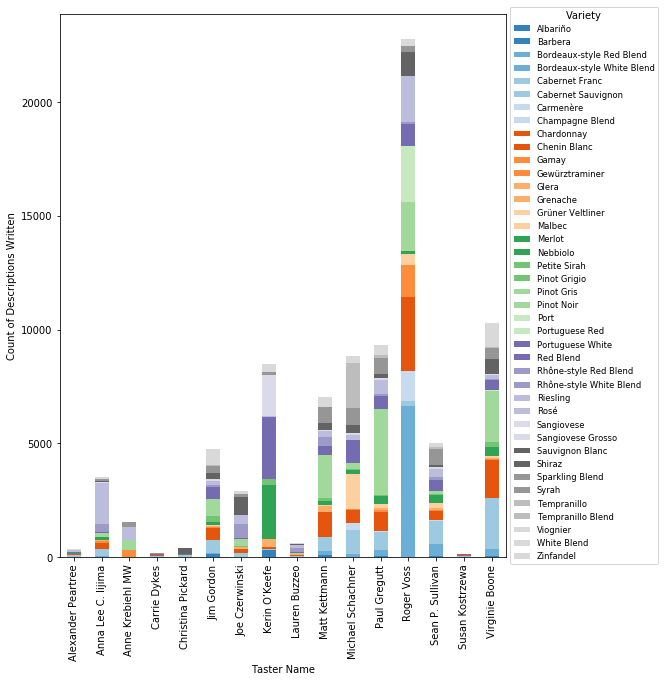

In [264]:
# COULD BE DONE: reverse order of legend.
toplot_stackedbar = winedata.groupby(['taster_name', 'variety'], as_index=False).count()
toplot_stackedbar = toplot_stackedbar[['taster_name', 'variety', 'title']]
toplot_stackedbar = toplot_stackedbar.pivot(index='taster_name', columns='variety', values='title')

toplot_stackedbar.plot(kind='bar', stacked=True, figsize=(8,10), cmap = 'tab20c') # 'hsv'
plt.legend(title='Variety', bbox_to_anchor=(1.35, 0.5), 
           loc='center right', fontsize='small')
plt.xlabel("Taster Name")
plt.ylabel("Count of Descriptions Written")
plt.savefig("../figures/stackedbar_n_descr_by_author_variety.png", bbox_inches='tight', dpi=200)
plt.show()

We note that the tasters did review a very different number of wines, and also that the distribution of wine varieties by taster vary greatly too.

In [210]:
# # TO DO, PLOT THE SAME DATA AS PERCENTAGE, not sure why not working...
# # stacked percentage barplot:
# toplot_percbar = toplot_stackedbar.fillna(0)
# toplot_percbar = (100. * toplot_percbar / toplot_percbar.sum())
# toplot_percbar.plot(kind='bar', stacked=True)
# toplot_percbar

#### Taster and Province

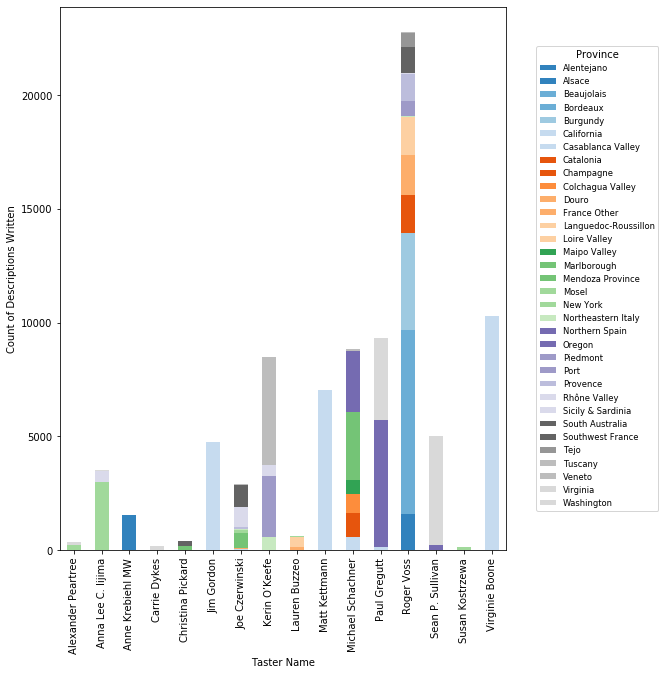

In [265]:
# COULD BE DONE: reverse order of legend.
toplot_stackedbar = winedata.groupby(['taster_name', 'province'], as_index=False).count()
toplot_stackedbar = toplot_stackedbar[['taster_name', 'province', 'title']]
toplot_stackedbar = toplot_stackedbar.pivot(index='taster_name', columns='province', values='title')

toplot_stackedbar.plot(kind='bar', stacked=True, figsize=(8,10), cmap = 'tab20c') # 'hsv'
plt.legend(title='Province', bbox_to_anchor=(1.35, 0.5), 
           loc='center right', fontsize='small')
plt.xlabel("Taster Name")
plt.ylabel("Count of Descriptions Written")
plt.savefig("../figures/stackedbar_n_descr_by_author_province.png", bbox_inches='tight', dpi=200)
plt.show()

The distribution of provinces reviewed vary greatly too. For instance, some tasters did only review wine from California.   

#### Vocabulary by taster

To test the second hypothesis, that the taster use a similar vocabulary, we can plot wordcould of the vocabulary used by the tasters.  

In [266]:
# TODO: wordcloud of most common words by taster

### 3.A Classification Based on the Descriptions

For building this content-based system based on the tasting descriptions, we make the assumption that these descriptions written by _sommeliers_ add more information about the taste of a wine than the variety and origin of the wines. If this is the case, we should not be able to build a model with 100% accuracy when predicting the _variety_ or _province_ of the wines based on the descriptions. This is an assumption that we will test.  

As that is not the main exercise of the project, we will only test one model and will not try to fine-tune it for days:  

#### A gradient-boosting model to classify wine varieties, provinces or taster names based on unigram tf-idf vectors

We choose the gradient booting approach, as it allows the estimation of the relative importance of the features. This information might be useful later when building the recommendation system.  

We will no train the gradient boost models in this notebook, as the process it time consuming. [This notebook](https://github.com/de-la-viz/winerec/blob/master/code/Training_Gradient_Boosting.ipynb) was used. Thus the next code chunks are commented. 

Below we load the trained model to evaluate the relative importance of the features. With gradient boosting, it is possible to ...

In [351]:
# vectorization using tfidf :
time0 = time.time()

# we only keep only 300 features:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=300, # max number of features
                               use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                               norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                               smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf = tfidf_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms = tfidf_vectorizer.get_feature_names()

# store the features in a dataframe:
tf_idf_features = pd.DataFrame(wine_tfidf.toarray(), columns=terms)

# add the different labels that interest us (indexes are the same):
tf_idf_features.loc[:, 'variety'] = winedata['variety']
tf_idf_features.loc[:, 'province'] = winedata['province']
tf_idf_features.loc[:, 'taster_name'] = winedata['taster_name']

print('Done! Vectorization took', time.time()-time0, 'seconds.')


Done! Vectorization took 4.410933971405029 seconds.


In [36]:
# EXAMPLE TO PREDICT THE VARIETY using tf-idf feature vectors:
# Y = tf_idf_features.variety 
X_tfidf = tf_idf_features.drop(['variety', 'province', 'taster_name'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.3, random_state=51)

In [37]:
# # Training the Gradient Boosting: !!! TAKES VERY LONG !!!
# time0 = time.time()

# gb = GradientBoostingClassifier() # default parameters (!)
# gb.fit(X_train, y_train) # train

# print('Done! Training took', time.time()-time0, 'seconds.')

# # Evaluating the model on train set:
# y_pred = gb.predict(X_train)
# print(classification_report(y_train, y_pred))


NameError: name 'X_tfidf' is not defined

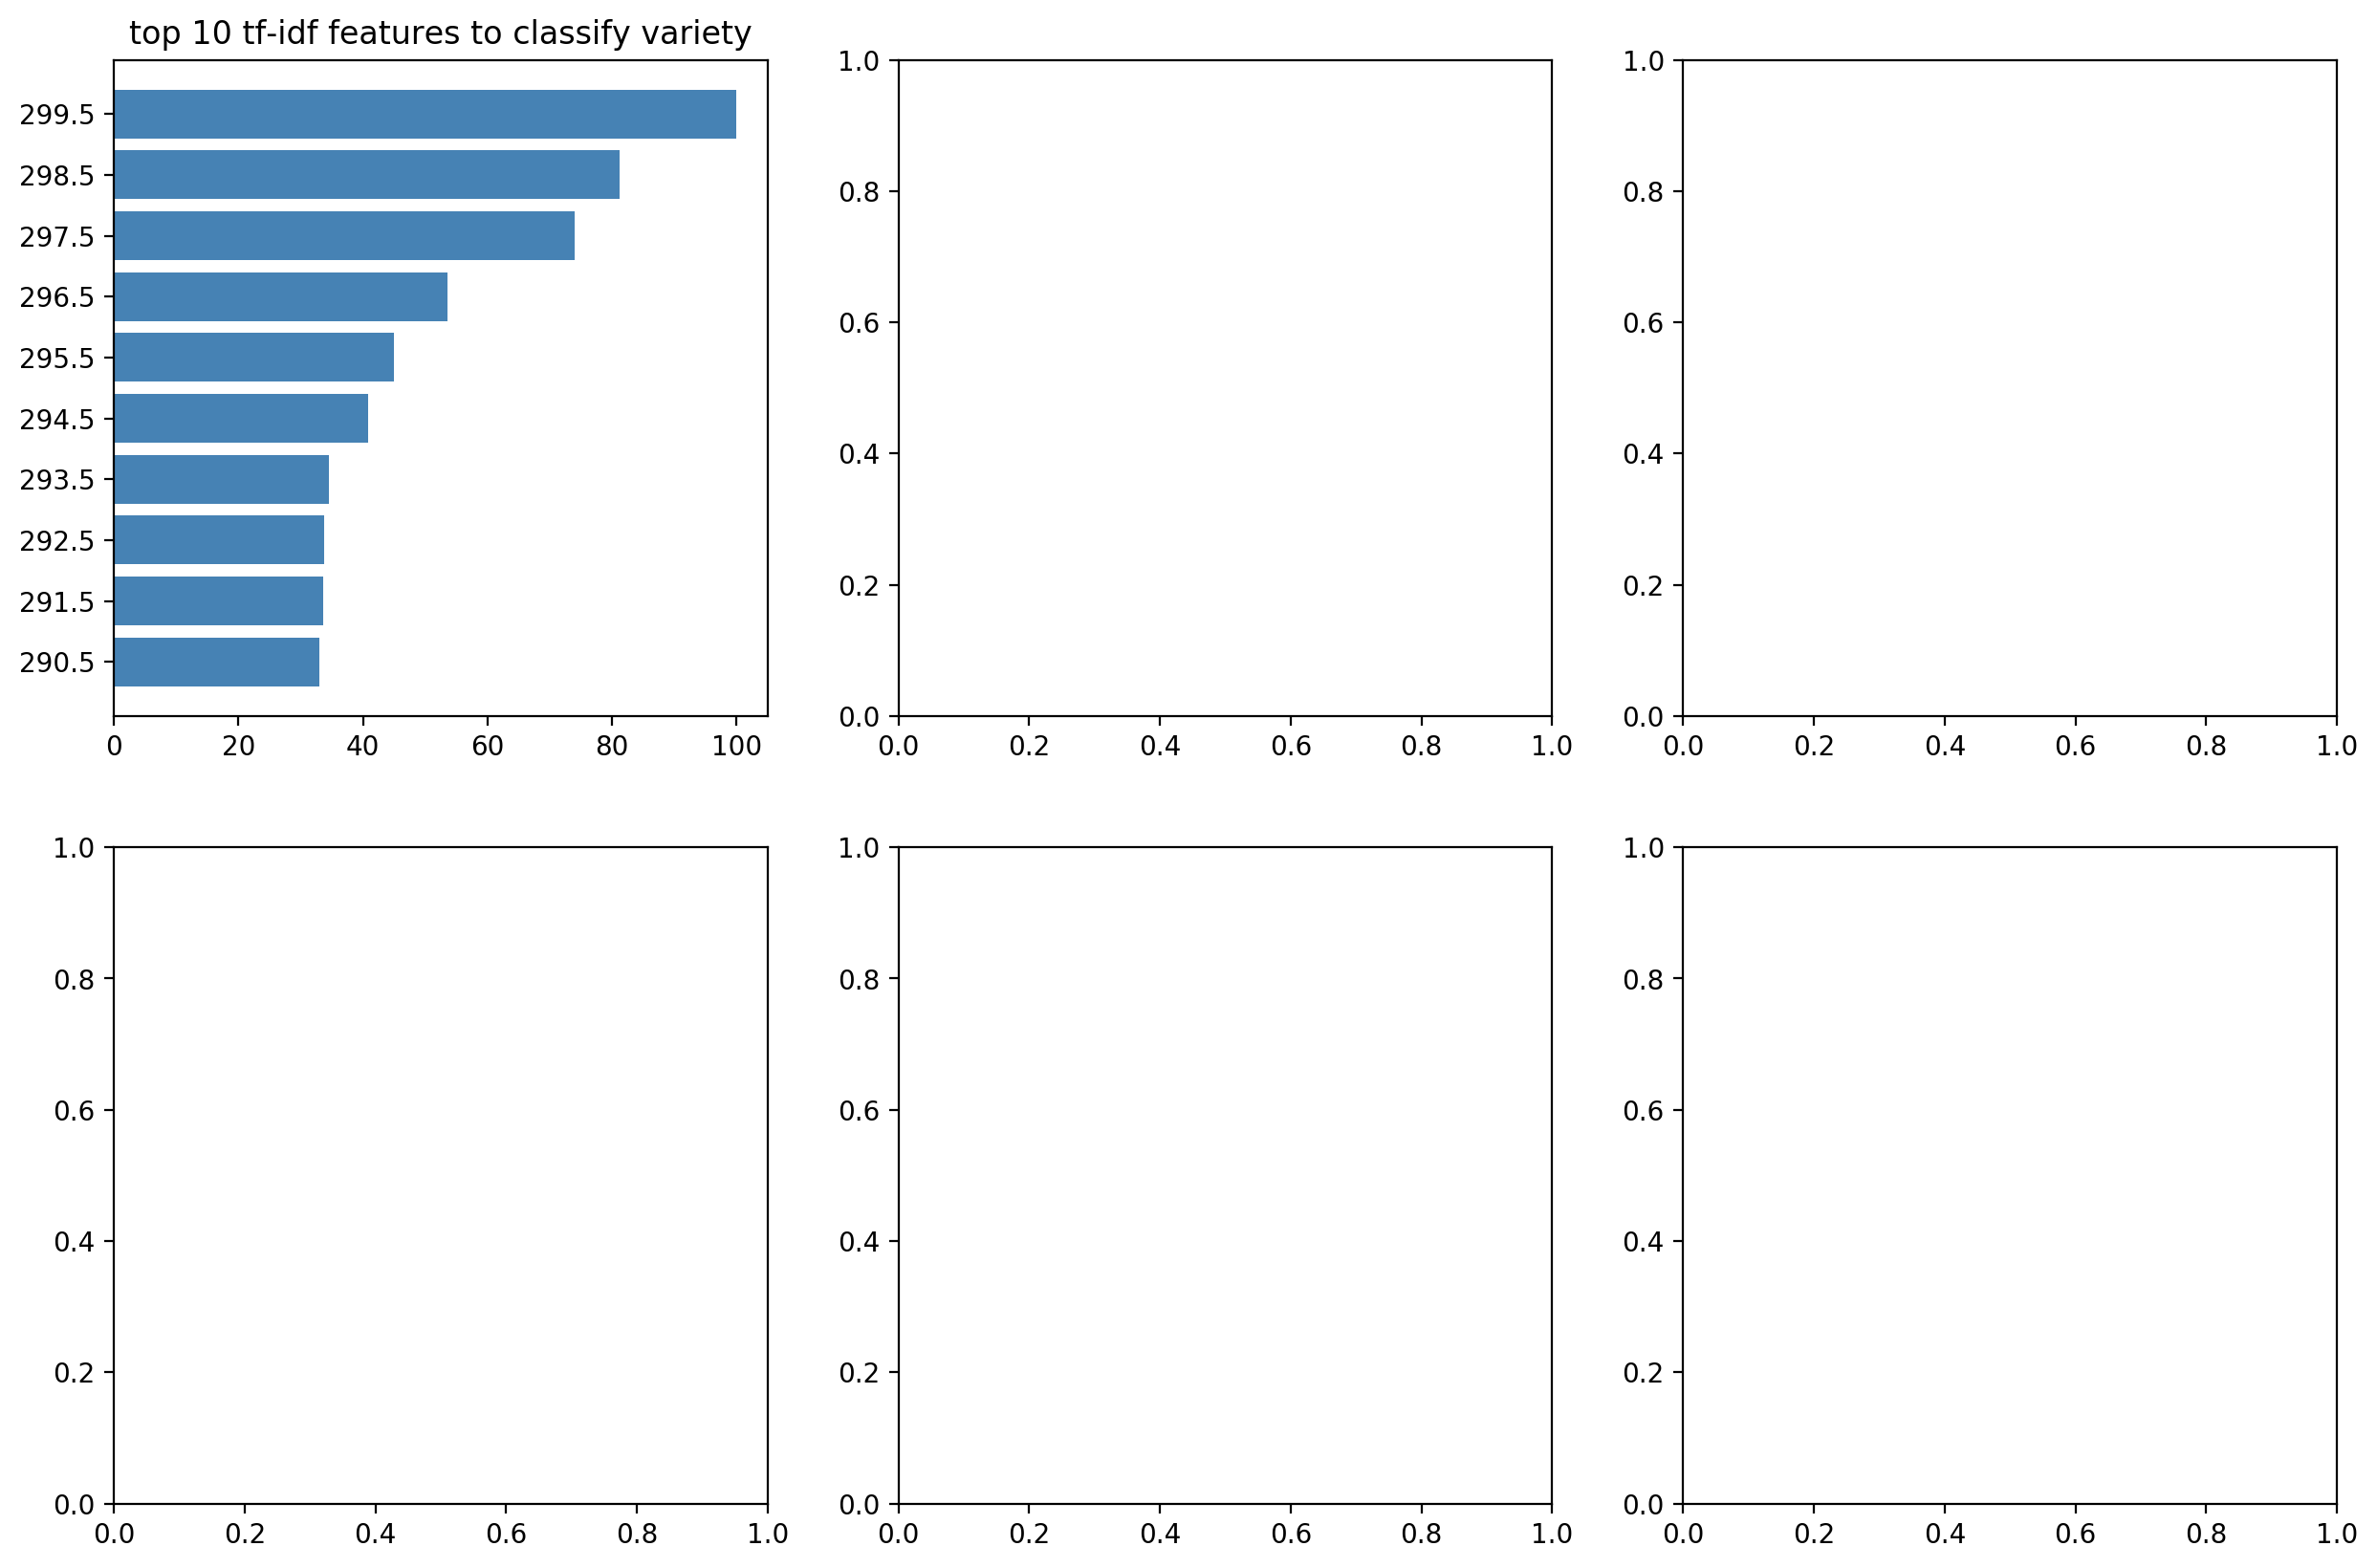

In [3]:
models_to_plot = ['gb_tfidf_variety.pkl', 'gb_tfidf_province.pkl', 
                  'gb_tfidf_taster_name.pkl', 'gb_bow_variety.pkl', 
                  'gb_bow_province.pkl', 'gb_bow_taster_name.pkl']
plot_titles = ['top 10 tf-idf features to classify variety', 
               'top 10 tf-idf features to classify province',
               'top 10 tf-idf features to classify taster', 
               'top 10 BoW features to classify variety',
               'top 10 BoW features to classify province', 
               'top 10 BoW features to classify taster']

fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', dpi=200)

axs = axs.ravel()

top_n = 10 # number of features to plot:

for i, model in enumerate(models_to_plot):
    pkl_filename = "../data/gradient_boost_predictions/" + model
    with open(pkl_filename, 'rb') as file:
        gb = pickle.load(file)
        
    feature_importance = gb.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance) # used to sort the features in the plot
    pos = np.arange(sorted_idx.shape[0]) + .5
    pos = pos[-top_n:]
    
    axs[i].barh(pos, feature_importance[sorted_idx][-top_n:], align='center', color='steelblue')
    axs[i].set_title(plot_titles[i])
    axs[i].set_yticks(pos)
    axs[i].set_yticklabels(list(X_tfidf.columns[sorted_idx][-top_n:]))
    axs[i].set_xlabel('Relative Importance')
    
    axs[i].spines['top'].set_visible(False) # for the style, remove frame
    axs[i].spines['right'].set_visible(False)

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)


### 3.B Clustering the Descriptions



In [ ]:
# could do here: wordclouds 

# cluster descriptions and compare the clusters. grouped by varieties? taster names? province? 

# could do this after, to evaluate the recommendations systems

## 4. Testing Different Recommendation Systems

We will try different recommendations systems, starting from the "simpler". They always consist of 2 steps: first a vectorization, where all the description are transformed to vectors, then a measure of similarity between those vectors to find the most similar wine to the target wine.  

1. BoW vectors and cosine similarity
2. tf-idf vectors and cosine similarity
3. pre-trained word2vec and cosine similarity
4. word2vec trained on the dataset
5. Topic modelling

For each of these systems, we will compare their top 5 recommendations for the most similar wine to two target wines that we really enjoyed last dinner, a red pinot noir from Oregon and a with a Gewürztraminer from Alsace. 

1. $winedata.iloc[14,:]$ "**Acrobat 2013 Pinot Noir (Oregon)**", described as "A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.". We tokenized (unigram) the description as following: 'sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated'.  

2. $winedata.iloc[7,:]$ "**Leon Beyer 2012 Gewurztraminer (Alsace)**", described as "This is a dry wine, very spicy, with a tight, taut texture and strongly mineral character layered with citrus as well as pepper. It's a food wine with its almost crisp aftertaste.". We tokenized (unigram) the description as following: 'dry', 'spicy', 'tight', 'taut', 'texture', 'strongly', 'mineral', 'character', 'layered', 'citrus', 'pepper', 'food', 'crisp', 'aftertaste'.

We vectorize our descriptions and compute the cosine distance with a target wine. This cosine distance will be our measure of similarity.     

As the computation of a full pairwise similarity matrix is too costly (it results in a ~100'000x100'000 matrix, the number of wines in the dataset), we compute the cosine similarity between one target wine vector and the full vectors and obtain a vector of similarities of 1x100'000. Then we sort it and select the top n wines that have the highest similarity to the target. Those will be our best recommendations.   

We define below some functions that will help us.

In [267]:
def print_wines(wine_indexes):
    """
        a generic function to print the most important feature of a or several wine(s).
        from their index(es): ! wine_indexes must be a list !
    """
    # print most important characteristic of wine(s),
    # from their index(es).
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = winedata.loc[index_, :]
        print(current_wine[['title', 'country', 'province', 'region_1', 'variety', 'taster_name']])
        print('Desciption: ', current_wine.description)
        print('Tokens: ', current_wine.tokenized_descriptions)
        print('------------------------------------------------------\n')

In [87]:
print_wines([14, 7]) # our two "target" wines

title          Acrobat 2013 Pinot Noir (Oregon)
country                                      US
province                                 Oregon
region_1                                 Oregon
variety                              Pinot Noir
taster_name                        Paul Gregutt
Name: 14, dtype: object
desciption:  A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.
tokens:  ['sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated']
------------------------------------------------------

title          Leon Beyer 2012 Gewurztraminer (Alsace)
country                                         France
province                                        Alsace
region_1                 

In [285]:
def return_target_vector(data_features, target_index):
    """
        given the index of a target wine,
        return the vectors of features 
        associated to this wine/index
        in the form of an "horizontal array",
        so it can be taken as input in the 
        sklearn.metrics.pairwise.cosine_similarity() fct.
    """
    target = data_features.iloc[target_index,:]
    return target.values.reshape(-1, 1).T

def compute_cosine_similarity_btw_target_and_features(data_features, target_vector):
    """
        takes a few seconds
    """
    return cosine_similarity(target_vector, data_features)

In [290]:
def recommend_top_n_wines(data_features, target_index, top_n ):
    """
        given a wine index (target_index), return the top_n
        most similar wine according to cosine distance with 
        other wines (data_features)
    """
    # get vector of target:
    target_vector = return_target_vector(data_features, target_index)
    
    # compute cosine distance: (takes a few seconds)
    cos_sim = compute_cosine_similarity_btw_target_and_features(data_features, target_vector)
    
    # build dataframe and add indexes based on input data:
    similarities = pd.DataFrame(cos_sim.T, columns=['cosine_sim'], index=bow_features.index)
    
    # sort and select top_n indexes (start at 1 to remove similarity with itself)
    moost_similar = similarities.sort_values('cosine_sim', ascending=False)[1:top_n+1]
    
    # return the indexes of those most similar wines:
    return list(moost_similar.cosine_sim.index)
    
    

### 4.1 BoW + Cosine Similarity

The simplest model is building vectors with the count of words by desccription: the so-called Bag of Words (BoW).

In [297]:
# vectorization using BoW :
time0 = time.time()

# note: we only keep 2000 features:
bow_vectorizer = CountVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_bow = bow_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_bow = bow_vectorizer.get_feature_names()

# store the features in a dataframe:
bow_features = pd.DataFrame(wine_bow.toarray(), columns=terms_bow)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 2.94010591506958 seconds.


Below is an example of recommendations for this simple recommender system. We find the 5 wines that are the most similar to our target wine [index 14] in the vector space defined by our BoW model:

In [299]:
# search for the most similar wines:
recommended_wines_bow = recommend_top_n_wines(bow_features, target_index=14, top_n=5)

# print results:
print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
print_wines([14])
print('\n')
print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
print_wines(recommended_wines_bow)

Hey #winerec, which wine should I drink if I enjoyed this one a lot?

title          Acrobat 2013 Pinot Noir (Oregon)
country                                      US
province                                 Oregon
region_1                                 Oregon
variety                              Pinot Noir
taster_name                        Paul Gregutt
Name: 14, dtype: object
Desciption:  A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.
Tokens:  ['sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated']
------------------------------------------------------



#winerec talking: Here are my top 5 recommendations, enjoy!

title          Evening Land 2014 Seven Springs Estate Vie

All are from Oregon and were tasted by the same person. Is it a coincidence? Before discussind and trying to evaluate these results in more details, we will try other models and compare their output.  

### 4.2 tf-idf + Cosine Similarity

This is a similar model, but we compute the similarity between wines in a tf-idf vector space. 

In [298]:
# vectorization using tf-idf :
time0 = time.time()

# note: we only keep 2000 features:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf = tfidf_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tfidf = tfidf_vectorizer.get_feature_names()

# store the features in a dataframe:
tfidf_features = pd.DataFrame(wine_tfidf.toarray(), columns=terms_tfidf)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 2.771799087524414 seconds.


In [304]:
# search for the most similar wines:
recommended_wines_tfidf = recommend_top_n_wines(tfidf_features, target_index=14, top_n=5)


In [316]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_tfidf)

### 4.3 tf-idf bigrams + Cosine Similarity

We noticed when reading a few descriptions and during the data exploration step that it might be worth looking at bigrams. Indeed, some taste qualifiers tipically consist of 2 words, like for instance: _tropical fruit_, _dried herb_, _dried sage_, _sour plums_, _dusty tannins_.  

We will keep as features the _unigrams_ AND _bigrams_ that have the highest tf-idf. I.e. our 2000 features are a mix of unigrams and bigrams. After inspection, it is not worth going for n-grams with n>2 (change *ngram_range* in *TfidfVectorizer*. This not so surprizing as we cleaned our text "quite intensively", removing diverse types of stopwords.  

In [308]:
# vectorization on BIGRAMS using tf-idf :
time0 = time.time()

# note: we only keep 2000 features:
tfidf_bigram_vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigram and bigram (min, max)
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf_bigram = tfidf_bigram_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tfidf_bigram = tfidf_bigram_vectorizer.get_feature_names()

# store the features in a dataframe:
tfidf_bigram_features = pd.DataFrame(wine_tfidf_bigram.toarray(), columns=terms_tfidf)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 18.50478196144104 seconds.


In [314]:
# # uncomment to inspect the unigrams and bigrams chosen as features:
# print(terms_tfidf_bigram)

In [315]:
# search for the most similar wines:
recommended_wines_tfidf_bigram = recommend_top_n_wines(tfidf_bigram_features, target_index=14, top_n=5)


In [318]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_tfidf_bigram)

### 4.4 pre-trained word2vec + cosine similarity

The word2vec model proposed by spaCy is trained on the [Common Crawl dataset](http://commoncrawl.org/). The disadvantage of this pre-trained model is that the data it used to train it might not reflect the peculiarities of the dataset of wine description. On the other end, we would need billion of data to train a good new word2vec model on our data; we only have ~100'000 wine reviews for now.  



In [322]:
# load larger spacy nlp model, that have pre-trained word vectors, unlike the small model:

# We still do not need PoS tags, dependencies or named entities, so we disable them (run faster!):
nlp_md = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])
# takes a few seconds

In [328]:
# vectorize the clean and processed descriptions
# apply spaCy model on clean data to get word2vec vector
descriptions_word2vec = winedata.token_descr_as_string.apply(nlp_md) 

In [334]:
# we extract the vector attributes of the spacy object
descriptions_word2vec_vectors = [descr.vector for descr in descriptions_word2vec]

n_dim_vectors = len(descriptions_word2vec_vectors[0])
print('features are', n_dim_vectors, 'dimensions vectors') # features are 300 dimensions vectors

# create features names
features_names = list(range(0, n_dim_vectors))
features_names = ['f'+str(i) for i in features_names]

# create a dataframe with features (word2vec vectors) as columns and wine indexes as index
pretrained_word2vec_features = pd.DataFrame(descriptions_word2vec_vectors, 
                                            columns=features_names, 
                                            index=winedata.index)
print('Shape of the features:', pretrained_word2vec_features.shape)
pretrained_word2vec_features.head()

features are 300 dimensions vectors
Shape of the features: (106873, 300)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
0,-0.159084,0.151556,-0.091375,-0.216663,0.060374,0.267113,-0.193304,0.200002,-0.077967,1.153212,...,-0.134386,0.068571,-0.222629,-0.086404,-0.412148,0.077141,0.076644,-0.486005,0.104647,0.011726
1,-0.266234,0.107008,-0.047260,-0.142627,0.048183,0.202625,-0.023727,0.147983,0.037657,1.282734,...,-0.085349,0.062646,-0.182010,-0.115452,-0.139977,-0.051843,0.097522,-0.400682,0.052112,0.003740
2,-0.126693,0.252434,0.006041,-0.145907,-0.020090,0.043690,-0.208207,0.255941,0.001707,0.637117,...,0.009742,0.038179,-0.205767,-0.201660,-0.266077,0.203259,0.072692,-0.410848,-0.092037,0.217177
3,-0.076028,0.151551,-0.082833,-0.064775,-0.035083,0.227857,0.048144,-0.049972,-0.087948,1.638700,...,-0.091685,0.060838,-0.207449,0.029507,0.038968,0.081510,0.066009,-0.126978,0.028869,-0.119433
4,-0.143007,0.277624,0.038183,-0.182341,-0.022961,0.317639,-0.057301,0.111317,-0.099029,1.366156,...,-0.086510,0.076488,-0.348332,-0.142161,-0.218571,0.040205,0.251255,-0.294934,0.123314,0.098643


We have now 300 features that represent each description. We can search for the most similar wine to our target again:

In [335]:
recommended_wines_pretrained_word2vec = recommend_top_n_wines(pretrained_word2vec_features, 
                                                              target_index=14, top_n=5)


In [337]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_pretrained_word2vec)

### 4.5 custom word2vec + cosine similarity

We can still try to train a word2vec model on our dataset, even if we know that we do not have sufficient data. The advantage of this custom word2vec is that it might differentiate better bewteen _taste qualifiers_ that are "in the grand scheme of words" (i.e. in the Common Crawl dataset) all in all quite similar. That is, the vectors describing different tastes like "cherry" or "apple" are probably quite parallel in 300 dimensions; their cosine distance and thus similarity is already high.  

In [340]:
# train the word2vec model on the wine descriptions corpus:
# using gensim
time0 = time.time()

custom_wine_word2vec_model = word2vec.Word2Vec(
    winedata.tokenized_descriptions, # use our clean and processed descriptions, as tokens (and not token_descr_as_string)
    workers=8,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=2,   # Minimum word count threshold. ! need to be the same as for tokenize_and_clean
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('Done! It took ', time.time()-time0, 'sec.')

Done! It took  15.974821090698242 sec.


In [343]:
# List of words in model.
vocab = custom_wine_word2vec_model.wv.vocab.keys()
print('The vector model has', len(vocab), 'words in vocabulary')

The vector model has 17986 words in vocabulary


Does this word2vec model trained on the wine descriptions make any sense? Let's have a look at some terms. Gensim provides a useful fonction to compute similarity between words in the model:

In [344]:
custom_wine_word2vec_model.wv.most_similar('fruit')[:10]

[('fruits', 0.6826236248016357),
 ('fruited', 0.4176090359687805),
 ('fruitiness', 0.41252291202545166),
 ('plum', 0.386529803276062),
 ('casing', 0.33399224281311035),
 ('abundant', 0.3262443542480469),
 ('cherry', 0.3192271590232849),
 ('currant', 0.29851579666137695),
 ('fruity', 0.2928653955459595),
 ('plums', 0.29167187213897705)]

In [345]:
custom_wine_word2vec_model.wv.most_similar('coffee')[:10]

[('espresso', 0.7364977598190308),
 ('coconut', 0.4137211740016937),
 ('char', 0.40317612886428833),
 ('nib', 0.401024729013443),
 ('cassis', 0.394816517829895),
 ('coffeebean', 0.3732198476791382),
 ('mocha', 0.372581422328949),
 ('black', 0.36031126976013184),
 ('graphite', 0.3580023944377899),
 ('bittersweet', 0.353835791349411)]

In [348]:
custom_wine_word2vec_model.wv.most_similar('fermented')[:10]

[('fermentation', 0.6953884363174438),
 ('vinified', 0.597784698009491),
 ('ferment', 0.5969667434692383),
 ('regimen', 0.5658590197563171),
 ('fermenting', 0.5410975813865662),
 ('ferments', 0.517162561416626),
 ('aged', 0.49121347069740295),
 ('tanks', 0.48181861639022827),
 ('whiskey', 0.477298378944397),
 ('bourbon', 0.47229740023612976)]

In [349]:
custom_wine_word2vec_model.wv.most_similar('french')[:10]

[('hungarian', 0.5879659056663513),
 ('saw', 0.5417608022689819),
 ('barrels', 0.537074089050293),
 ('quarter', 0.5220044255256653),
 ('bésoleil', 0.4955867528915405),
 ('american', 0.4944269061088562),
 ('sees', 0.471820592880249),
 ('york', 0.4405598044395447),
 ('seeing', 0.43068060278892517),
 ('barrique', 0.4161950945854187)]

In [350]:
custom_wine_word2vec_model.wv.most_similar('mastered')[:10]

[('tierce', 0.6742549538612366),
 ('experiment', 0.6740505695343018),
 ('page', 0.6643773317337036),
 ('honing', 0.6637792587280273),
 ('penfolds', 0.6631691455841064),
 ('struggled', 0.6563915610313416),
 ('sebastiani', 0.6484766006469727),
 ('talbott', 0.6472561359405518),
 ('luchtel', 0.6431086659431458),
 ('roman', 0.6419849395751953)]

This does not look quite bad and it is fun! The result for the last word tested "mastered" is a bit strange however, it has a quite high similarity to apparently not so similar words.     

We can **visualize our vector model in 2D with PCA**. As this is quite time consuming, it is done in [another notebook](). The resulting plot is loaded below:

In [353]:
# # save model in order to load it from the PCA plotting notebook:
# pkl_filename = '../data/custom_wine_word2vec_model.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(custom_wine_word2vec_model, file)

Discussion:

* inverse problem: predict description from other predictors

Future Work:
* add the possibility to compute most similar wine to any vector of taste words. 